In [1]:
# A fancier tokenizer (e.g. spacy's) would likely give cleaner results 
from spacy.tokenizer import Tokenizer
from spacy.lang.nl import Dutch
dutch = Dutch()
tokenizer = Tokenizer(dutch.vocab)
def nl_tokenize(nl_sent):
     doc = tokenizer( nl_sent.rstrip() )
     return list(tok.text for tok in doc)
 
# for a faster but rougher test you could avoid that big dependency by using something like:
import re
def simple_tokenize(text):  # spacy's tokenizer would be more robust, but this avoids that as a big depdenency, for a quick test
    ' split string into words '
    l = re.split('[\s!@#$%^&*()"\':;/.,?\xab\xbb\u2018\u2019\u201a\u201b\u201c\u201d\u201e\u201f\u2039\u203a\u2358\u275b\u275c\u275d\u275e\u275f\u2760\u276e\u276f\u2e42\u301d\u301e\u301f\uff02\U0001f676\U0001f677\U0001f678-]+', text)
    return list(e   for e in l  if len(e)>0)

2023-09-20 19:52:15.222111: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 19:52:15.306217: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 19:52:17.524681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 19:52:17.526258: I tensorflow/comp

In [3]:
import wetsuite.phrases.collocation
import wetsuite.datasets

kv   = wetsuite.datasets.load('kamervragen')
coll = wetsuite.phrases.collocation.Collocation()

for kv_id, kv_details in list(kv.data.items())[:5000]:
    vraagdata = kv_details['vraagdata']

    for number in vraagdata:
        try:
            vraag   , _ = vraagdata[number]['vraag']
            antwoord, _ = vraagdata[number]['antwoord']
        except KeyError: # TODO: fix
            continue

        coll.consume_tokens(  simple_tokenize(    vraag.lower() )  )
        coll.consume_tokens(  simple_tokenize( antwoord.lower() )  )

coll.counts()



{'from_tokens': 4340514, 'uni': 84299, 'grams': 6646903}

In [4]:
#coll.cleanup_unigrams(5)
coll.cleanup_grams(5)

coll.counts()

{'from_tokens': 4340514, 'uni': 84299, 'grams': 228541}

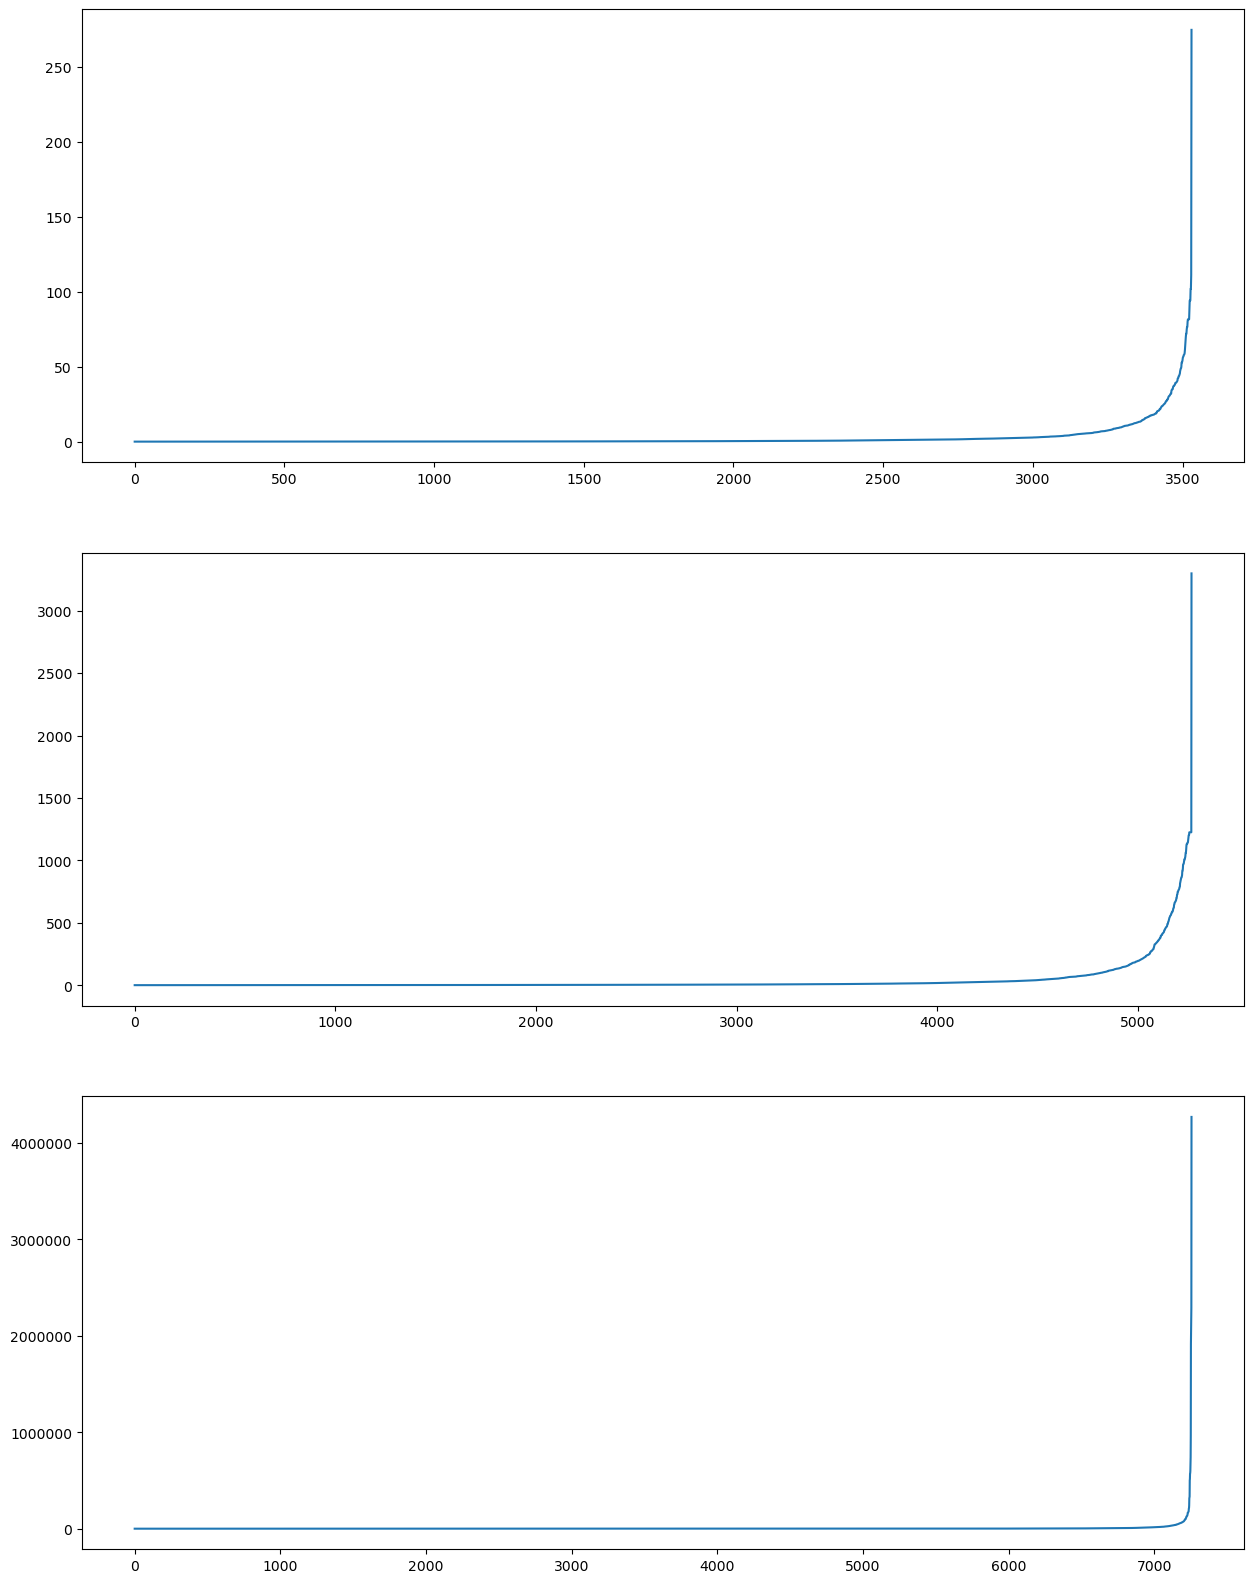

In [5]:
import numpy, matplotlib.pyplot

fig, axes = matplotlib.pyplot.subplots(3,1, figsize=(15,20))

for ai, method in enumerate( ('mik', 'mik2', 'mik3') ):
    scored_grams = coll.score_grams( method=method, sort=True )[-10000:]

    if 0:
        tup_counts = list(tup_count                                           for strtup, score,  tup_count, uni_counts in scored_grams)
        uniprod    = list( wetsuite.phrases.collocation.product(uni_counts)   for strtup, score,  tup_count, uni_counts in scored_grams)

        axes[ai].plot( tup_counts,                                                 c='r', label='tup_count')
        axes[ai].set_ylim(0,numpy.percentile(tup_counts,90))
        axes[ai].set_title(method)
        y2 = axes[ai].twinx()
        y2.plot( uniprod, c='b', label='uniprod')
        y2.set_ylim=(0,numpy.percentile(uniprod,50))
        continue

    if 0:
        axes[ai].hist( list(tup_count for strtup, score,  tup_count, uni_counts in scored_grams   if tup_count>10),   align='mid', rwidth=0.9, range=(0,100), bins=100 )
    
    if 1:   
        axes[ai].plot( list(score for strtup, score,  tup_count, uni_counts in scored_grams   if tup_count>10) )

In [6]:
#coll.cleanup_unigrams(mincount=10)
#coll.cleanup_grams(mincount=10)
scored_grams = coll.score_grams( method='mik2' )
for strtup, score,  tup_count, uni_counts in scored_grams[-5000:]: # TODO: figu
    print(' %9.3f   %50s    %20s %20s=%d'%(score, ' '.join(strtup),   tup_count, uni_counts, wetsuite.phrases.collocation.product(uni_counts)) )

     5.055                                   financiële positie                      93          [2776, 755]=2095880
     5.056                                            herkent u                     187         [210, 40346]=8472660
     5.056                                                om te                    2971       [36663, 58332]=2138626116
     5.057                                          dgb energie                       5             [8, 757]=6056
     5.062                stimulering duurzame energieproductie                      11        [54, 730, 26]=1024920
     5.063                                       wnb vergunning                      10            [46, 526]=24196
     5.063                             playing field instrument                       7        [34, 36, 339]=414936
     5.064                                       noch ontkennen                       6            [311, 28]=8708
     5.067                                            den brede       

In [5]:
# sentences from dutch news sites
sents = open('unsorted/testdata/news.txt').readlines()
print( 'Number of sentences: %d'%len(sents) )

#choose a subset and tokenize those sentences
import random
train_sents = sents
#train_sents = random.sample(sents, 100000)

train_sents_tok = []
for sent in train_sents:
    train_sents_tok.append( sent_tokenize(sent) )
#some_sents_tok

FileNotFoundError: [Errno 2] No such file or directory: 'unsorted/testdata/news.txt'

In [8]:
import wetsuite.helpers.net

#boek = wetsuite.helpers.net.download('https://www.gutenberg.org/cache/epub/21848/pg21848.txt').decode('utf8')
#boek_tok = simple_tokenize( boek.replace('\n', ' ') )
#boek_tok

# burgerlijk wetboek 7
import bs4
bwb7_xml = wetsuite.helpers.net.download('https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0005290/2008-03-26_0/xml/BWBR0005290_2008-03-26_0.xml').decode('utf8')
soup = bs4.BeautifulSoup(bwb7_xml, features='xml')
text = []
for al in soup.select('lid al'):
    text.extend( al.find_all(text=True) )
bwb7_text = ''.join(text)
#print( text )


coll = wetsuite.phrases.collocation.Collocation()
coll.consume_tokens(  wetsuite.phrases.collocation.simple_tokenize( bwb7_text )  )

#coll.cleanup_unigrams(mincount=10)
coll.cleanup_grams(mincount=3)
scored_grams = coll.score_grams( method='mik2' )
for strtup, score,  tup_count, uni_counts in scored_grams[-5000:]:
    print(' %9.3f   %50s    %20s %20s=%d'%(score, ' '.join(strtup),   tup_count, uni_counts, wetsuite.phrases.collocation.product(uni_counts)) )





     0.270                                               Aan de                       3            [7, 5843]=40901
     0.270                                          de algemene                       6           [5843, 28]=163604
     0.270                                           de overige                       3            [5843, 7]=40901
     0.270                                           tijdens de                       3            [7, 5843]=40901
     0.270                                               de rol                       3            [5843, 7]=40901
     0.270                                             de order                       3            [5843, 7]=40901
     0.270                                     de bewijsstukken                       3            [5843, 7]=40901
     0.270                                          de bewaring                       3            [5843, 7]=40901
     0.270                                         de afkoopsom                

## gensim.phrases example

In [4]:
# train
from gensim.models.phrases import Phrases
nl_connectors = frozenset( 'de een   van voor met in op bij   en of'.split() )
phrase_model = Phrases(train_sents_tok, min_count=1, threshold=0.4, connector_words=nl_connectors, scoring='npmi', delimiter='\u00a0')


In [9]:
# choose a smaller subset of sentences and see which phrases are _commonly_ detected
import collections
count=collections.defaultdict(int)

#test_sents = random.sample(sents, 100000)
test_sents = sents

for test_sent in test_sents:
    sent_tok = sent_tokenize( test_sent )
    result = phrase_model[sent_tok]
    for tok in result:
        if '\u00a0' in tok:
            count[tok] += 1

for tok, cnt in sorted( count.items(), key=lambda x:x[1], reverse=True )[:1000]:
    print( '%5d  %20s '%(cnt, tok) )
    if cnt==1:
        break

 7915             niet meer 
 5964              meer dan 
 4570                kun je 
 4501            nog steeds 
 4268                Ik heb 
 4106                Als je 
 4095              dit jaar 
 4011              te maken 
 3595       het coronavirus 
 3195                heb ik 
 2957            onder meer 
 2954                Ik ben 
 2653           alleen maar 
 2308            De politie 
 2190              nog eens 
 2172             dit soort 
 2166             te maken. 
 2152               net als 
 2074            vorig jaar 
 1918                ben ik 
 1865      het coronavirus. 
 1818               Ik denk 
 1807            dit moment 
 1708             deze week 
 1646             heel veel 
 1639               Je kunt 
 1582           ieder geval 
 1576            te houden. 
 1555          jaar geleden 
 1483           steeds meer 
 1478              feit dat 
 1465             We hebben 
 1429               Ik vind 
 1399           vorige week 
 1396         

In [ ]:
test_sents = [sent_tokenize(sent)   for sent in random.sample(sents, 1000000)]

for phrase, score in sorted( phrase_model.find_phrases( test_sents ).items(), key=lambda x:x[1], reverse=True)[:1000]:
    w1,w2 = phrase.split('\u00a0',1)
    print('%5.2f  %20s %-20s'%(score,w1,w2))



## NLTK example

In [8]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from nltk.corpus import stopwords

flat = []
for toksent in train_sents_tok:
    flat.extend( toksent )

top = 1000
window_size = 6

bigram_measures = BigramAssocMeasures()
col_finder = BigramCollocationFinder.from_words(flat, window_size=window_size)
col_finder.apply_word_filter(lambda w: len(w) < 2 or w.lower() in stopwords.words('dutch'))
col_finder.apply_freq_filter(3)

: 

: 

In [ ]:
# calculate the top results by T-score
#   possible measures: .raw_freq, .pmi, .likelihood_ratio, .chi_sq, .phi_sq, .fisher, .student_t, .mi_like, .poisson_stirling, .jaccard, .dice
results = col_finder.nbest( bigram_measures.student_t, top)

print("Top %s collocations:"%top)
for k, v in results:
    print(str(k), ", ", str(v))

Top 1000 collocations:
ieder ,  geval
vorig ,  jaar
miljoen ,  euro
jaar ,  geleden
vorige ,  week
gebruik ,  maken
twee ,  weken
aantal ,  besmettingen
we ,  onze
volgend ,  jaar
groot ,  deel
zoveel ,  mogelijk
snel ,  mogelijk
heel ,  erg
per ,  dag
Den ,  Haag
Apple ,  Watch
meter ,  afstand
miljard ,  euro
gaan ,  we
weken ,  geleden
Laten ,  we
net ,  zoals
twee ,  jaar
laten ,  weten
vijf ,  jaar
Openbaar ,  Ministerie
Tweede ,  Kamer
legt ,  uit.
liet ,  weten
komt ,  doordat
moeten ,  zijn.
rond ,  uur
volgende ,  week
paar ,  jaar
jaar ,  oud
wel ,  degelijk
euro ,  per
drie ,  jaar
afgelopen ,  week
we ,  willen
moeten ,  we
Verenigde ,  Staten
New ,  York
ten ,  opzichte
ter ,  plaatse
Donald ,  Trump
laat ,  weten.
24 ,  uur
komende ,  weken
weer ,  terug
Net ,  zoals
elke ,  dag
ruim ,  miljoen
zullen ,  moeten
hele ,  dag
afgelopen ,  jaar
hadden ,  we
we ,  wel
we ,  zien
mensen ,  gaan
misschien ,  wel
Pro ,  League
1,5 ,  meter
positief ,  getest
Mark ,  Rutte
maatreg

## Our own

In [7]:
import wetsuite.phrases.collocation

coll = wetsuite.phrases.collocation.Collocation()

for sent in sents:
    toksent = wetsuite.phrases.collocation.simple_tokenize(sent)
    coll.consume_text( toksent )


print( "Cleanup")
print( coll.counts() )
coll.cleanup_unigrams(mincount=3)
coll.cleanup_grams(mincount=10)
print( coll.counts() )

print( "Scoring")
scores = coll.score_grams( method='mik2', sort=True )
for strtup, score,  tup_count, uni_counts in scores[-3000:]:
    print(' %9.3f   %50s    %20s %20s=%d'%(score, ' '.join(strtup),   tup_count, uni_counts, wetsuite.phrases.collocation.product(uni_counts)) )


Cleanup
{'uni': 335496, 'grams': 32386278}
{'uni': 113749, 'grams': 260483}
Scoring
     7.613                                         laste gelegd                      18            [50, 532]=26600
     7.615                                   lachende leugenaar                      10            [72, 114]=8208
     7.625                                     Groninger Museum                      11            [38, 261]=9918
     7.628                                 arrestaties verricht                      16            [92, 228]=20976
     7.631                                          des Bouvrie                      10            [546, 15]=8190
     7.633                                 Olympisch Comité IOC                      34      [120, 145, 136]=2366400
     7.677                                            high tech                      20           [195, 167]=32565
     7.680                                             Jean Luc                      25           [281, 181]=508

In [1]:
ttt = """
Voor het gerechtshof gelden, bij deze rechtsgedingen, de voorschriften, ten aanzien van het rechtsgeding in eerste aanleg.

Het gerechtshof doet uitspraak in eerste aanleg, tevens in hoogste ressort.

De rechter kan in de procedure op verzoek van een partij of ambtshalve de Hoge Raad een rechtsvraag stellen ter beantwoording bij wijze van prejudiciële beslissing, indien een antwoord op deze vraag nodig is om op de vordering of het verzoek te beslissen en rechtstreeks van belang is: voor een veelheid aan vorderingsrechten die gegrond zijn op dezelfde of soortgelijke feiten en uit dezelfde of soortgelijke samenhangende oorzaken voortkomen, of voor de beslechting of beëindiging van talrijke andere uit soortgelijke feiten voortvloeiende geschillen, waarin dezelfde vraag zich voordoet. De bevoegdheid, bedoeld in de vorige volzin, komt niet toe aan de rechter bij wie een verzoek, bedoeld in artikel 907, eerste lid, van Boek 7 van het Burgerlijk Wetboek , in behandeling is.

Alvorens de vraag te stellen, stelt de rechter partijen in de gelegenheid zich uit te laten over het voornemen om een vraag te stellen, alsmede over de inhoud van de te stellen vraag.

De beslissing waarbij de vraag wordt gesteld, vermeldt voorts het onderwerp van geschil, de door de rechter vastgestelde feiten en de door partijen ingenomen standpunten. Tevens bevat de beslissing een uiteenzetting dat met de beantwoording van de vraag wordt voldaan aan onderdeel a of b van het eerste lid. Tegen de beslissing om een vraag te stellen, alsmede tegen de beslissing ter zake van de inhoud van de vraag, staat geen voorziening open.

De griffier zendt onverwijld een afschrift van de beslissing aan de Hoge Raad. De griffier zendt afschriften van de andere op de procedure betrekking hebbende stukken op diens verzoek aan de griffier van de Hoge Raad.

De rechter houdt de beslissing op de vordering of het verzoek aan totdat een afschrift van de beslissing van de Hoge Raad is ontvangen.

Indien in een andere lopende procedure het antwoord op de vraag rechtstreeks van belang is om op de vordering of het verzoek te beslissen, kan de rechter op verzoek van een partij of ambtshalve de beslissing aanhouden totdat de Hoge Raad uitspraak heeft gedaan. Alvorens te beslissen als bedoeld in de eerste zin, stelt de rechter partijen in de gelegenheid zich daarover uit te laten. De rechter houdt de beslissing niet aan indien partijen te kennen hebben gegeven voortzetting van de procedure te verlangen. Tegen de beslissing om al dan niet aan te houden, staat geen voorziening open.

Tenzij de Hoge Raad, gehoord de procureur-generaal bij de Hoge Raad, aanstonds beslist overeenkomstig het achtste lid, stelt hij partijen in de gelegenheid om binnen een door de Hoge Raad te bepalen termijn schriftelijk opmerkingen te maken.

De Hoge Raad kan bepalen dat ook anderen dan partijen binnen een daartoe te bepalen termijn in de gelegenheid worden gesteld om schriftelijke opmerkingen te maken. De aankondiging hiervan geschiedt op een door de Hoge Raad te bepalen wijze.

Schriftelijke opmerkingen worden door een advocaat bij de Hoge Raad getekend en ter griffie van de Hoge Raad ingediend. De griffier zendt onverwijld een afschrift aan partijen.

Indien het belang der zaak dit geraden doet voorkomen, kan de Hoge Raad, hetzij ambtshalve, hetzij op een daartoe strekkend verzoek, een dag bepalen voor mondelinge of schriftelijke toelichting door de advocaten van partijen. De Hoge Raad kan, indien hij een mondelinge toelichting heeft bevolen, degenen die ingevolge het tweede lid schriftelijke opmerkingen hebben gemaakt, uitnodigen ter zitting aanwezig te zijn teneinde over hun opmerkingen te worden gehoord.

De in het vierde lid bedoelde toelichting kan worden gegeven door een andere dan de volgens het derde lid aangewezen advocaat. De daaruit voor een partij ontstane vermeerdering van kosten is niet in de in artikel 394, tweede lid , bedoelde beslissing over de kosten begrepen. Een schriftelijke toelichting wordt door de advocaat getekend en ter griffie van de Hoge Raad ingediend. De griffier zendt onverwijld een afschrift aan de door deze andere partijen gestelde advocaten bij de Hoge Raad.

Na het verstrijken van de termijn voor het maken van schriftelijke opmerkingen, dan wel na de mondelinge of schriftelijke toelichting, neemt de procureur-generaal bij de Hoge Raad conclusie, hetzij onmiddellijk, hetzij op een daartoe te bepalen dag. De griffier zendt onverwijld een afschrift van de conclusie aan de door partijen gestelde advocaten bij de Hoge Raad.

Nadat de procureur-generaal bij de Hoge Raad overeenkomstig het zesde lid conclusie heeft genomen, bepaalt de Hoge Raad de dag waarop hij zal beslissen. De Hoge Raad kan de vraag herformuleren. Tenzij de herformulering van ondergeschikte betekenis is, stelt de Hoge Raad partijen in de gelegenheid om binnen een door hem te bepalen termijn schriftelijke opmerkingen te maken.

De Hoge Raad ziet af van beantwoording indien hij oordeelt dat de vraag zich niet voor beantwoording bij wijze van prejudiciële beslissing leent of de vraag van onvoldoende gewicht is om beantwoording te rechtvaardigen. De Hoge Raad kan zich bij de vermelding van de gronden van zijn beslissing beperken tot dit oordeel.

Indien het antwoord op de vraag, nadat deze is gesteld, niet meer nodig is om in de procedure als bedoeld in artikel 392, eerste lid , op de vordering of het verzoek te beslissen, kan de Hoge Raad, indien hem dat geraden voorkomt, de vraag desondanks beantwoorden.

De Hoge Raad begroot in zijn beslissing de kosten die partijen ingevolge dit artikel hebben gemaakt.

De griffier zendt onverwijld een afschrift van de beslissing aan de rechter die de vraag heeft gesteld en aan partijen. De griffier zendt eveneens onverwijld aan de rechter die de vraag heeft gesteld een afschrift van de conclusie van de procureur-generaal en afschriften van de in het derde en vierde lid genoemde schriftelijke opmerkingen en schriftelijke toelichtingen.

Behoudens indien het antwoord op de vraag niet meer nodig is om op de vordering of het verzoek te beslissen, beslist de rechter, nadat hij partijen de gelegenheid heeft gegeven zich schriftelijk over de uitspraak van de Hoge Raad uit te laten, met inachtneming van deze uitspraak.

De rechter kan onder de proceskosten waarin een partij veroordeeld wordt, ook opnemen het door de Hoge Raad begrote bedrag voor de ingevolge artikel 393, derde en vierde lid , door de wederpartij gemaakte kosten.

De grossen van in Nederland gewezen vonnissen, van beschikkingen van de Nederlandse rechter en van in Nederland verleden authentieke akten alsmede van andere bij de wet als executoriale titel aangewezen stukken kunnen in geheel Nederland worden ten uitvoer gelegd.

Zij moeten aan het hoofd voeren de woorden: In naam van de Koning.

Zij kunnen niet worden ten uitvoer gelegd dan na betekening aan de partij tegen wie de executie zich zal richten.

Behoudens het bepaalde in de artikelen 985-994 , kunnen noch beslissingen, door vreemde rechters gegeven, noch buiten Nederland verleden authentieke akten binnen Nederland ten uitvoer worden gelegd.

De gedingen kunnen opnieuw bij de Nederlandse rechter worden behandeld en afgedaan.

Het staat aan de executant vrij beslag te leggen op alle voor beslag vatbare goederen, waartoe hij bevoegd is zijn vordering te verhalen.

Hij is verplicht een beslag dat strekt tot verhaal op een goed dat aan een ander dan de schuldenaar toebehoort, en dat ten laste van die ander wordt gelegd, binnen acht dagen aan de schuldenaar te betekenen.

Wordt een beslag van de in het vorige lid bedoelde strekking ten laste van de schuldenaar gelegd, dan is de beslaglegger verplicht het binnen acht dagen aan de ander te betekenen of, zo hij diens recht niet kent, onverwijld nadat hij van dat recht kennis heeft gekregen. Indien de ander, voordat acht dagen na deze betekening zijn verstreken, schriftelijk aan de deurwaarder mededeelt zich tegen het verhaal op zijn goed te verzetten, geldt het beslag jegens hem slechts als conservatoir en kan de executie jegens hem slechts plaatsvinden uit hoofde van een tegen hem verkregen executoriale titel om deze executie te dulden.

Geschillen die in verband met een executie rijzen, worden gebracht voor de rechtbank die naar de gewone regels bevoegd zou zijn, of in welker rechtsgebied de inbeslagneming plaatsvindt, zich een of meer van de betrokken zaken bevinden of de executie zal geschieden. In afwijking van de vorige zin worden geschillen die rijzen in verband met de executie van een door de kantonrechter afgegeven executoriale titel voor de kantonrechter gebracht die de executoriale titel heeft afgegeven.

Tot het verkrijgen van een voorziening bij voorraad kan het geschil ook worden gebracht in kort geding voor de voorzieningenrechter van de volgens het eerste lid bevoegde rechtbank. In zaken die ten gronde door de kantonrechter worden behandeld en beslist, is ook de kantonrechter bevoegd tot het geven van deze voorziening. Daarbij is op de kantonrechter van toepassing hetgeen over de voorzieningenrechter is bepaald.

Onverminderd zijn overige bevoegdheden kan de voorzieningenrechter desgevorderd de tenuitvoerlegging schorsen voor een bepaalde tijd of totdat op het geschil zal zijn beslist, dan wel bepalen dat de tenuitvoerlegging slechts tegen zekerheidstelling mag plaatsvinden of worden voortgezet. Hij kan beslagen, al of niet tegen zekerheidsstelling, opheffen. Hij kan gedurende de tenuitvoerlegging herstel bevelen van verzuimde formaliteiten met bepaling van welke op het verzuim gevolgde formaliteiten opnieuw moeten worden verricht en te wiens laste de kosten daarvan zullen komen. Hij kan bepalen dat een in het geding geroepen derde de voortzetting van de tenuitvoerlegging moet gedogen dan wel zijn medewerking daaraan moet verlenen, al of niet tegen zekerheidsstelling door de executant.

Voor zover de zaak zich niet leent voor behandeling in kort geding, kan de voorzieningenrechter in plaats van de vordering af te wijzen de zaak op verlangen van de eiser verwijzen naar de rechtbank met bepaling van de dag waarop zij op de rol moet komen. Tegen een gedaagde die op voormeld tijdstip niet verschijnt en ook voor de voorzieningenrechter niet bij advocaat is verschenen, wordt slechts verstek verleend, zo hij tegen dit tijdstip bij exploit is opgeroepen met inachtneming van de voor dagvaarding voorgeschreven termijn, dan wel van de termijn die op verlangen van de eiser door de voorzieningenrechter bepaald is.

De deurwaarder die met de executie is belast en daarbij op een bezwaar stuit dat een onverwijlde voorziening nodig maakt, kan zich met een daarvan door hem opgemaakt proces-verbaal bij de voorzieningenrechter vervoegen ten einde deze in kort geding tussen de betrokken partijen te doen beslissen. De voorzieningenrechter zal de behandeling aanhouden tot de partijen zijn opgeroepen, tenzij hij, gelet op de aard van het bezwaar, een onmiddellijke beslissing geboden acht. De deurwaarder die zijn voormelde bevoegdheid zonder instemming van de executant uitoefent, kan persoonlijk in de kosten worden veroordeeld, indien deze uitoefening nodeloos was.

Verzet tegen de executie door een derde geschiedt door dagvaarding van zowel de executant als de geëxecuteerde.

In zaken betreffende een executie die volgens de tweede en de derde titel van dit Boek of titel 9 van Boek 3 van het Burgerlijk Wetboek worden ingeleid door indiening van een verzoek aan de voorzieningenrechter van de rechtbank, is bevoegd de voorzieningenrechter in wiens rechtsgebied de te executeren zaken zich geheel of grotendeels bevinden of de executie zal geschieden.

De indiening van verzoeken krachtens de artikelen 459, derde lid , 461b , 462, tweede lid , artikel 463, vijfde lid , 463a , 465 , 481, eerste lid , 496, tweede lid , en 506, tweede lid , kan ook door een deurwaarder geschieden. Hetzelfde geldt voor een verzoek krachtens artikel 234, derde lid, van Boek 3 van het Burgerlijk Wetboek , indien de executie door een pandhouder geschiedt, of krachtens artikel 251 van dat Boek . Indien een deurwaarder het verzoek indient, geldt zijn kantoor als gekozen woonplaats van de verzoeker.

De tenuitvoerlegging van een veroordeling tot schadevergoeding op te maken bij staat, vangt aan met de betekening aan de wederpartij van een staat waarin het beloop van de schade waarvan de vereffening wordt gevorderd, gespecificeerd wordt opgegeven.

Het exploot vermeldt de roldatum en, indien dan een terechtzitting wordt gehouden, het uur daarvan. De bepalingen betreffende dagvaarding zijn van overeenkomstige toepassing. Bevoegd is de rechter die in eerste instantie over de hoofdzaak heeft geoordeeld.

Ingeval van geschil over een krachtens vonnis of beschikking te stellen zekerheid wordt daarover op vordering van de meest gerede partij in kort geding beslist door de voorzieningenrechter van de rechtbank, door wie of door wiens college de zaak in eerste aanleg is behandeld, of, in geval van een arbitraal vonnis, van de rechtbank van het arrondissement waarin de plaats van de arbitrage is gelegen.

Gaat het om een vonnis of beschikking van de kantonrechter, dan wordt de vordering voor deze ingesteld. Gaat het om een uitspraak van een gerechtshof in eerste aanleg, dan wordt de vordering ingesteld voor de voorzieningenrechter van de rechtbank die naar de gewone regels in eerste aanleg bevoegd zou zijn.

Zowel de rechter die het vonnis of de beschikking, bedoeld in de vorige leden, wijst als de rechter die over het geschil omtrent de te stellen zekerheid oordeelt, kan een termijn bepalen: waarbinnen de zekerheid moet worden aangeboden of gesteld, op straffe van verval van de bevoegdheid met het oog op welker uitoefening de zekerheidstelling is bevolen; waarbinnen een aangeboden zekerheid door de wederpartij moet worden aanvaard of geweigerd, op straffe van verval van haar bevoegdheid zekerheidstelling te eisen.

De rechter die de termijn heeft bepaald, kan deze op verzoek van de meest gerede partij, in te dienen voordat de termijn is verstreken, verlengen. Tegen een beschikking krachtens dit lid is geen hogere voorziening toegelaten.

Indien rekening en verantwoording moet worden gedaan aan belanghebbenden die allen of voor een deel onbekend of afwezig zijn, dagvaardt de rekenplichtige hen allen tot het opnemen en goedkeuren van de rekening op de wijze als vermeld in artikel 54, tweede lid .

De bekende belanghebbenden worden bovendien gedagvaard op de wijze als voor ieder van hen is bepaald in de zesde afdeling van de eerste titel van het Eerste Boek .

De termijn van dagvaarding is ten minste drie maanden.

Wordt tegen alle belanghebbenden verstek verleend, dan onderzoekt de rechter ambtshalve de rechtmatigheid en de gegrondheid van de vordering. Indien dit onderzoek niet leidt tot afwijzing van de vordering, stelt de rechter het saldo aan de hand van de overgelegde bescheiden vast en sluit hij de rekening. Tegen dit vonnis staat geen verzet open.

De rechter geeft zodanige beslissing over de kosten van het geding als hij geraden acht. Een gedaagde tegen wie verstek is verleend, wordt niet verwezen in de kosten.

In de zaken die ingevolge het bij of krachtens Boek 2 van het Burgerlijk Wetboek bepaalde met een verzoek worden ingeleid, is, tenzij anders is bepaald, bevoegd de rechter van de woonplaats van de rechtspersoon. Nadat de rechtspersoon is opgehouden te bestaan blijft deze rechter bevoegd in zaken betreffende de vereffening, de benoeming van bewaarders van boeken en bescheiden en het verlenen van machtiging tot inzage in boeken en bescheiden.

Het verzoekschrift vermeldt, onverminderd het in artikel 278 bepaalde, de naam en de woonplaats van de rechtspersoon.

De rechter gelast in ieder geval de oproeping van de rechtspersoon.

Het verzet van een schuldeiser onderscheidenlijk een wederpartij overeenkomstig de artikelen 100 lid 3 , 182 lid 3 , 316 lid 2 , 334l , of 404 lid 5 van boek 2 van het Burgerlijk Wetboek wordt door de rechter met de meeste spoed behandeld. Indien verschillende verzoeken zijn ingediend, wordt op alle tezamen beschikt.

Van de dag waarop de mondelinge behandeling zal plaatsvinden, wordt door de griffier aankondiging gedaan in de Nederlandse Staatscourant en in een landelijk verspreid dagblad.

Voorts geeft de griffier kennis aan het kantoor van het handelsregister, waar de vennootschap is ingeschreven.

De rechtbank hoort de schuldeisers onderscheidenlijk de wederpartijen die zijn verschenen.

Hoger beroep moet binnen drie weken na de dagtekening van de eindbeschikking worden ingesteld bij de ondernemingskamer van het gerechtshof Amsterdam. De voorgaande leden vinden in hoger beroep overeenkomstige toepassing.

Een afschrift van het oproepingsbericht of van het exploot van oproeping houdende de procesinleiding waarbij een vordering bij de rechtbank wordt ingesteld als bedoeld in de artikelen 336 , 342 en 343 van boek 2 van het Burgerlijk Wetboek wordt onverwijld door de eiser aan de vennootschap betekend.

Binnen twee weken na de betekening stelt de vennootschap de niet opgeroepen aandeelhouders schriftelijk in kennis van de inhoud van het oproepingsbericht.

Van ieder vonnis wordt een afschrift door de griffier behalve aan partijen tevens aan de vennootschap toegezonden. Een afschrift van het vonnis als bedoeld in artikel 340 van boek 2 van het Burgerlijk Wetboek wordt onverwijld door de eiser aan de verweerders en de vennootschap betekend.

Tegen het vonnis is geen verzet van derden mogelijk als bedoeld in artikel 376 van dit wetboek.

Een rechtsvordering tot teruggave van een roerende zaak, gegrond op artikel 6.7 van de Erfgoedwet , wordt ingesteld tegen de bezitter of, bij ontstentenis van een bezitter, tegen de houder van het cultuurgoed voor de naar de regels van dit wetboek bevoegde rechter.

Op straffe van nietigheid dienen tezamen met het oproepingsbericht te worden bezorgd of betekend: een document waarin de roerende zaak waarvan teruggave wordt gevorderd, wordt beschreven en waaruit blijkt dat deze zaak een cultuurgoed is in de zin van artikel 6.1, onder c, van de Erfgoedwet en derhalve van wezenlijk belang voor het cultureel erfgoed van de verdragsstaat waaruit het cultuurgoed afkomstig is; een verklaring van de verdragsstaat waaruit het cultuurgoed afkomstig is, dat dit cultuurgoed buiten het grondgebied van die staat is geraakt met schending van de regels die door die staat in overeenstemming met de doelstellingen van het Unesco-verdrag 1970, bedoeld in artikel 6.1, onder a, van de Erfgoedwet zijn vastgesteld ter zake van de uitvoer en de eigendomsoverdracht van cultuurgoederen, dan wel dat dit cultuurgoed is ontvreemd in die verdragsstaat.

Het verzoekschrift waarmee het verzoek, bedoeld in artikel 907, eerste lid, van Boek 7 van het Burgerlijk Wetboek wordt ingeleid, vermeldt: de namen en de woonplaatsen van de verzoekers; een omschrijving van de gebeurtenis of de gebeurtenissen waarop de overeenkomst betrekking heeft; een korte omschrijving van de overeenkomst; een duidelijke omschrijving van het verzoek en de gronden waarop het berust.

Aan het verzoekschrift wordt de overeenkomst als bijlage toegevoegd.

Het gerechtshof Amsterdam is bij uitsluiting bevoegd tot kennisneming van een verzoek in eerste aanleg als in dit artikel bedoeld.

In afwijking van artikel 282, tweede lid , behoeft geen afschrift van een verweerschrift en de overlegde bescheiden verzonden te worden aan de personen ten behoeve van wie de overeenkomst is gesloten. De rechter kan, in afwijking van artikel 290, eerste en tweede lid , bevelen, dat het verzoekschrift, de verweerschriften, de op de zaak betrekking hebbende bescheiden en de processen-verbaal en zonodig een vertaling hiervan in één of meer andere talen dan de Nederlandse taal op één of meer door hem aan te wijzen internetadressen worden geplaatst, zodanig dat deze door de personen ten behoeve van wie de overeenkomst is gesloten ten behoeve van latere kennisneming kunnen worden opgeslagen. Tevens kan de rechter bevelen dat de verzoekers desverlangd aan een persoon ten behoeve van wie de overeenkomst is gesloten afschriften verstrekken van de in de tweede zin genoemde stukken.

De oproeping van de aan de verzoekers bekende personen ten behoeve van wie de overeenkomst is gesloten geschiedt bij gewone brief, tenzij de rechter anders bepaalt. Bovendien geschiedt de oproeping door aankondiging daarvan in één of meer door de rechter aan te wijzen nieuwsbladen, waarbij tevens rechtspersonen als bedoeld in artikel 1014 worden opgeroepen. Hierbij wordt naast de plaats, de dag en het uur van de terechtzitting telkens op een door de rechter aan te geven wijze melding gemaakt van een korte omschrijving van de overeenkomst en van de gevolgen van toewijzing van het verzoek. Tevens wordt vermeld op welke wijze inzage en afschrift kan worden verkregen van de in het vierde lid genoemde stukken en wordt gewezen op de bevoegdheid om een verweerschrift in te dienen. Tenzij de rechter anders bepaalt, dragen de verzoekers zorg voor de oproeping ingevolge dit lid. De rechter kan gelasten dat de in dit lid bedoelde informatie ook op andere wijze wordt bekend gemaakt. Indien de curator in faillissement de overeenkomst heeft gesloten, gelast de rechter de verzoekers oproeping op een door hem te bepalen wijze van bekende en onbekende schuldeisers. Indien er personen zijn ten behoeve van wie de overeenkomst is gesloten, die geen woonplaats of verblijf in Nederland hebben en een voor Nederland bindende internationale of Unie-regeling niet een wijze van oproeping voorschrijft, gelast de rechter oproeping op een door hem bepaalde wijze van deze personen, zonodig in één of meer andere talen dan de Nederlandse taal.

De rechter kan bevelen dat verzoekers de namen en woonplaatsen van de aan hen bekende personen ten behoeve van wie de overeenkomst is gesloten, uiterlijk op een door de rechter te bepalen dag en op een door hem te bepalen wijze aan hem worden overgelegd. De verzoekers kunnen zich daarbij houden aan de laatste hun bekende woonplaatsen van de in de eerste zin bedoelde personen.

De rechter kan, indien hij de dag en het uur van de behandeling bepaalt, tevens bepalen dat verweerschriften in afwijking van artikel 282, eerste lid , uiterlijk voor een door hem vast te stellen tijdstip voor de behandeling moeten worden ingediend. Artikel 282, vierde lid, mist toepassing.

De rechter kan, op verzoek van partijen of van een van hen dan wel ambtshalve, in elke stand van de procedure een verschijning van partijen ter terechtzitting bevelen teneinde het verloop van de procedure te bespreken en daaromtrent aanwijzingen te verstrekken en bevelen te geven. Partijen verschijnen ter terechtzitting in persoon of bij advocaat. Van het verhandelde wordt een proces-verbaal opgemaakt, dat door de rechter en de griffier wordt ondertekend. Tegen de beslissing om al dan niet een verschijning te bevelen, staat geen voorziening open.

Procedures betreffende geschillen in de beëindiging waarvan de overeenkomst voorziet, worden door de indiening van het verzoek, bedoeld in artikel 907, eerste lid, van Boek 7 van het Burgerlijk Wetboek , van rechtswege geschorst, ook indien reeds de dag is bepaald waarop het vonnis, het arrest of de beschikking zal worden uitgesproken.

Het geschorste geding wordt overeenkomstig artikel 227, eerste lid , hervat: voor zover in de procedure om een beslissing wordt verzocht ter zake van een geschil in de beëindiging waarvan de overeenkomst niet voorziet; indien de in artikel 908, tweede lid, van Boek 7 van het Burgerlijk Wetboek bedoelde termijn is verstreken, nadat een gerechtigde onder de overeenkomst binnen die termijn de in dat lid bedoelde mededeling heeft gedaan; indien onherroepelijk vaststaat dat het verzoek niet tot toewijzing zal leiden; indien de overeenkomst overeenkomstig artikel 908, vierde lid, van Boek 7 van het Burgerlijk Wetboek wordt opgezegd; indien de behandeling van het verzoek met het oog op de belangen van een gerechtigde onder de overeenkomst en alle omstandigheden in aanmerking genomen, onaanvaardbaar lang duurt en naar verwachting nog onaanvaardbaar lang zal duren; indien de partijen in de geschorste procedure daarmee instemmen.

Artikel 907, vijfde lid, van Boek 7 van het Burgerlijk Wetboek is niet van toepassing op hetgeen in een ingevolge het tweede lid hervat geding wordt gevorderd.

Behoudens de gevallen, bedoeld in het tweede lid, wordt na schorsing van een hangende procedure het geding op verzoek van de meest gerede partij van de rol afgevoerd indien de in artikel 908, tweede lid, van Boek 7 van het Burgerlijk Wetboek bedoelde termijn is verstreken.

De artikelen 225, tweede lid, tweede zin, en derde lid en 227, tweede en derde lid , zijn van toepassing.

De rechter kan bevelen dat één of meer deskundigen zullen berichten over de voor het verzoek van belang zijnde punten.

Behoudens de toepassing van artikel 289 kan de rechter bepalen dat de kosten voortvloeiende uit de toepassing van de bepalingen van deze titel ten laste komen van één of meer verzoekers.

Een afschrift van de beschikking wordt door de griffier schriftelijk zo spoedig mogelijk verstrekt aan de verzoekers.

De beschikking en de overeenkomst die daarbij verbindend is verklaard liggen ter griffie ter inzage en afschrift van de gerechtigden onder de overeenkomst. De rechter kan, in plaats daarvan, bevelen dat de beschikking en de overeenkomst en zonodig een vertaling hiervan in één of meer andere talen dan de Nederlandse taal op één of meer door hem aan te wijzen internetadressen worden geplaatst, zodanig dat deze door de gerechtigden onder de overeenkomst ten behoeve van latere kennisneming kunnen worden opgeslagen. Tevens kan de rechter bevelen dat de verzoekers desverlangd aan een gerechtigde onder de overeenkomst afschriften verstrekken van de beschikking en de overeenkomst.

Aan de bekende gerechtigden onder de overeenkomst en aan de in de procedure verschenen rechtspersonen als bedoeld in artikel 1014 , wordt zo spoedig mogelijk schriftelijk mededeling gedaan van de beschikking tot verbindendverklaring, tenzij de rechter anders bepaalt. Bovendien wordt van de verbindendverklaring zo spoedig mogelijk aankondiging gedaan in één of meer door de rechter aan te wijzen nieuwsbladen. Hierbij wordt telkens op een door de rechter aan te geven wijze melding gemaakt van een korte omschrijving van de overeenkomst, in het bijzonder de wijze waarop vergoeding kan worden verkregen of anderszins een beroep op de overeenkomst kan worden gedaan en, indien de overeenkomst dat bepaalt, de termijn waarbinnen daarop aanspraak dient te worden gemaakt, alsmede van de gevolgen van de verbindendverklaring, en worden de termijn waarbinnen en de wijze waarop de gerechtigden onder de overeenkomst zich van de gevolgen van de verbindendverklaring kunnen bevrijden, vermeld. Tevens wordt vermeld op welke wijze inzage en afschrift kan worden verkregen van de beschikking en de overeenkomst die daarbij verbindend is verklaard. De rechter kan bevelen dat ook van andere dan de in dit lid genoemde gegevens melding wordt gemaakt. Tenzij de rechter anders bepaalt, dragen de verzoekers zorg voor de in dit lid bedoelde melding en aankondiging. De rechter kan gelasten dat de in dit lid bedoelde gegevens ook op andere wijze bekend worden gemaakt. Indien er gerechtigden onder de overeenkomst zijn die geen woonplaats of verblijf in Nederland hebben en een voor Nederland bindende internationale of Unie-regeling niet een wijze van aankondiging voorschrijft, gelast de rechter aankondiging op een door hem te bepalen wijze ten behoeve van deze gerechtigden, zonodig in één of meer andere talen dan de Nederlandse taal.

Zo spoedig mogelijk nadat het verzoek tot verbindendverklaring onherroepelijk is afgewezen, dragen de verzoekers er zorg voor dat de personen ten behoeve van wie de overeenkomst is gesloten, daar op een door de rechter te bepalen wijze van op de hoogte worden gebracht.

De verzoekers kunnen het gerechtshof Amsterdam verzoeken om ter uitvoering van de in het derde en vierde lid bedoelde meldingen en aankondigingen nadere aanwijzingen te verstrekken.

Beroep in cassatie staat uitsluitend open indien het verzoek wordt afgewezen en kan uitsluitend door de verzoekers gezamenlijk worden ingesteld.

Herroeping staat uitsluitend open voor de in artikel 907, eerste lid, van Boek 7 van het Burgerlijk Wetboek bedoelde stichtingen of verenigingen gezamenlijk, en voor de overige verzoekers gezamenlijk. Indien de in de eerste zin bedoelde stichtingen of verenigingen zijn ontbonden, staat herroeping open voor een stichting of vereniging, bedoeld in artikel 1014 . Herroeping van de beschikking op verzoek van stichtingen en verenigingen als bedoeld in de eerste of tweede zin, heeft geen gevolgen voor een gerechtigde onder de overeenkomst die zich tegen die gevolgen verzet.

Indien een veelheid aan personen door een gebeurtenis of gelijksoortige gebeurtenissen is benadeeld, kan, voordat een zaak aanhangig is, de rechtbank, teneinde een overeenkomst, bedoeld in artikel 907, eerste lid, van Boek 7 van het Burgerlijk Wetboek , te beproeven, op verzoek van een stichting of vereniging, bedoeld in artikel 907, derde lid, onderdeel f, van Boek 7 van het Burgerlijk Wetboek en van de persoon of personen die voor deze gebeurtenis of gebeurtenissen verantwoordelijk worden gehouden, dan wel op verzoek van een van hen, een verschijning ter zitting van deze partijen bevelen.

Het verzoekschrift vermeldt: de naam en woonplaats van de verzoeker of verzoekers; de naam en woonplaats van de in het eerste lid bedoelde partijen waarvan verschijning wordt verzocht; een omschrijving van de gebeurtenis of gebeurtenissen waarop het verzoek betrekking heeft; een omschrijving van het geschil of de geschillen die partijen verdeeld houdt; een omschrijving van het verzoek.

Indien de rechter het verzoek toestaat, bepaalt hij de plaats, de dag en het uur waarop de verschijning zal plaatsvinden. Verzoekers en andere partijen, die daartoe zijn opgeroepen, zijn verplicht te verschijnen. Indien een verzoeker of partij als bedoeld in de tweede zin niet verschijnt, kan zij worden veroordeeld tot vergoeding van de vergeefs aangewende kosten van degenen die wel zijn verschenen.

Bij een verschijning ter zitting kan besproken worden hoe verzoekers en de opgeroepen partijen de totstandkoming van een in het eerste lid bedoelde overeenkomst zullen trachten te bereiken. Ook kan een andere wijze van beëindiging van geschillen ter zake van de in het eerste lid bedoelde gebeurtenis of gebeurtenissen worden besproken. Artikel 191, tweede lid, tweede en derde zin , is van toepassing.

Deze titel is van toepassing op procedures betreffende een vordering als bedoeld in artikel 305a en 305c van Boek 3 van het Burgerlijk Wetboek . Met uitzondering van artikel 1018c, eerste lid , is deze titel niet van toepassing op zaken als bedoeld in artikel 254 .

De tweede titel van het Eerste Boek is van toepassing, tenzij in deze titel anders is bepaald.

Artikel 93 is niet van toepassing.

Onverminderd artikel 30a, derde lid , vermeldt de procesinleiding waarmee de collectieve vordering bedoeld in artikel 305a van Boek 3 van het Burgerlijk Wetboek wordt ingesteld: een omschrijving van de gebeurtenis of de gebeurtenissen waarop de collectieve vordering betrekking heeft; een omschrijving van de personen tot bescherming van wier belangen de collectieve vordering strekt; een omschrijving van de mate waarin de te beantwoorden feitelijke en rechtsvragen gemeenschappelijk zijn; een omschrijving van de wijze waarop voldaan is aan de ontvankelijkheidseisen van artikel 305a, eerste tot en met derde lid, van Boek 3 van het Burgerlijk Wetboek of van de gronden waarop het zesde lid van dat artikel van toepassing is; de gegevens die de rechter in staat stellen om voor deze collectieve vordering een Exclusieve Belangenbehartiger aan te wijzen, voor het geval andere collectieve vorderingen voor dezelfde gebeurtenis overeenkomstig artikel 1018d worden ingesteld.

Op straffe van niet ontvankelijkheid maakt eiser binnen twee dagen na indiening van de procesinleiding daarvan aantekening in het centraal register voor collectieve acties als bedoeld in artikel 305a, zevende lid, van Boek 3 van het Burgerlijk Wetboek . De aantekening gaat vergezeld van een uittreksel van de procesinleiding.

Tenzij de rechter eiser aanstonds niet ontvankelijk verklaart overeenkomstig het tweede lid, houdt hij de zaak aan totdat een termijn van drie maanden na aantekening in het register, bedoeld in het tweede lid, is verstreken. Tenzij ingevolge artikel 1018d, tweede lid , deze termijn is verlengd of een andere collectieve vordering voor dezelfde gebeurtenis of gebeurtenissen is ingesteld, wordt na het verstrijken van de termijn de behandeling van de zaak voortgezet in de stand waarin zij zich bevindt.

Naast de gegevens, bedoeld in artikel 111, tweede lid , vermeldt de griffier in het oproepingsbericht de verplichting van de eiser om van de zaak aantekening te maken in het register, bedoeld in het tweede lid, en de daaraan verbonden gevolgen ingevolge dit artikel. In afwijking van artikel 111, tweede lid, onder c, ligt de dag waarop de verweerder ten laatste zijn verweerschrift kan indienen zes weken nadat de in het derde lid bedoelde termijn is verstreken.

Inhoudelijke behandeling van de collectieve vordering vindt slechts plaats indien en nadat de rechter heeft beslist: dat eiser voldoet aan de ontvankelijkheidseisen van artikel 305a, eerste tot en met derde lid, van Boek 3 van het Burgerlijk Wetboek of dat niet aan deze eisen behoeft te worden voldaan op grond van het zesde lid van dit artikel; dat de eiser voldoende aannemelijk heeft gemaakt dat het voeren van deze collectieve vordering efficiënter en effectiever is dan het instellen van een individuele vordering doordat de te beantwoorden feitelijke en rechtsvragen in voldoende mate gemeenschappelijk zijn, het aantal personen tot bescherming van wier belangen de vordering strekt, voldoende is en, indien de vordering strekt tot schadevergoeding, dat zij alleen dan wel gezamenlijk een voldoende groot financieel belang hebben; dat niet summierlijk van de ondeugdelijkheid van de collectieve vordering blijkt op het moment van indiening van de procesinleiding. In afwijking van artikel 30i, vierde lid , mag de verweerder volstaan met de verweren die betrekking hebben op het onder a tot en met c genoemde, totdat hierover is beslist.

Indien een collectieve vordering voor dezelfde gebeurtenis of gebeurtenissen wordt ingesteld na het aanhangig worden van de collectieve vordering bedoeld in het eerste lid maar voordat de termijn bedoeld in artikel 1018d is aangevangen, wordt de zaak, zo nodig na verwijzing, gevoegd met de reeds aanhangige collectieve vordering als bedoeld in het tweede lid, onder a.

Binnen drie maanden na de aantekening in het register als bedoeld in artikel 1018c, tweede lid , kan een rechtspersoon als bedoeld in artikel 305a van Boek 3 van het Burgerlijk Wetboek een collectieve vordering instellen voor dezelfde gebeurtenis of gebeurtenissen als waarop de collectieve vordering bedoeld in artikel 1018c, eerste lid, betrekking heeft, over gelijksoortige feitelijke en rechtsvragen, onder vermelding van de aantekening. De collectieve vordering wordt ingesteld bij dezelfde rechtbank als waar de eerder in het register aangetekende collectieve vordering is ingesteld. Artikel 1018c, eerste lid, is van toepassing.

De rechter kan de in het vorige lid bedoelde termijn met maximaal drie maanden verlengen indien binnen een maand na de aantekening een rechtspersoon als bedoeld in artikel 305a van Boek 3 van het Burgerlijk Wetboek ter griffie heeft laten aantekenen dat hij een collectieve vordering wil instellen voor dezelfde gebeurtenis of gebeurtenissen als waarop de collectieve vordering bedoeld in artikel 1018c, eerste lid , betrekking heeft, onder vermelding van de aantekening in het register, maar dat de termijn van drie maanden niet volstaat.

Voor de toepassing van het eerste Boek worden de overeenkomstig dit artikel ingestelde collectieve vorderingen na indiening en betekening of bezorging van de procesinleiding als bedoeld in artikel 112 gezamenlijk behandeld als een zaak. De dag waarop de verweerder ten laatste als verweerder kan verschijnen in de zin van artikel 30a, derde lid, onder c , ligt vier weken na het verstrijken van de termijn op grond van het eerste en tweede lid.

De rechter wijst uit de eisers die overeenkomstig artikel 1018c of 1018d een collectieve vordering hebben ingesteld en voldoen aan de eisen voor ontvankelijkheid van artikel 305a, eerste tot en met derde lid, van Boek 3 van het Burgerlijk Wetboek , de meest geschikte eiser aan als exclusieve belangenbehartiger, waarbij hij de volgende omstandigheden in aanmerking neemt: de omvang van de groep personen voor wie de eiser opkomt; de grootte van het door deze groep vertegenwoordigde financiële belang; andere werkzaamheden die de eiser verricht voor de personen voor wie hij opkomt in of buiten rechte; eerdere door de eiser verrichte werkzaamheden of ingestelde collectieve vorderingen. Tegen deze uitspraak staat geen rechtsmiddel open.

De rechter beoordeelt daarnaast wat de collectieve vordering precies inhoudt, voor welke nauw omschreven groep personen de exclusieve belangenbehartiger de belangen in deze collectieve vordering behartigt en of de aan een bepaalde plaats gebonden aard van de collectieve vordering aanleiding geeft voor behandeling van de zaak bij een ander gerecht.

De eiser die als exclusieve belangenbehartiger wordt aangewezen, treedt in deze procedure op voor de belangen van alle personen in de nauw omschreven groep, bedoeld in het tweede lid, en als vertegenwoordiger van de niet als exclusieve belangenbehartiger aangewezen eisers. De niet als exclusieve belangenbehartiger aangewezen eisers blijven partij in de procedure. De exclusieve belangenbehartiger verricht de proceshandelingen. De rechter kan bepalen dat ook de niet aangewezen eisers proceshandelingen mogen verrichten.

Als de aard van de collectieve vordering of van de eisers of de belangen van de personen voor wie zij opkomen daartoe aanleiding geven, kan de rechter ervoor kiezen om verschillende exclusieve belangenbehartigers in een collectieve actie aan te wijzen.

De uitspraak ingevolge dit artikel wordt door de exclusieve belangenbehartiger aangetekend in het in artikel 1018c, tweede lid , bedoelde register.

De procedure over een collectieve vordering heeft geen gevolg voor en leidt niet tot gebondenheid van personen behorend tot de nauw omschreven groep personen wier belangen in deze collectieve vordering worden behartigd indien zij binnen een door de rechter te bepalen termijn van ten minste een maand na de in het derde lid bedoelde aankondiging van de uitspraak, bedoeld in artikel 1018e, eerste en tweede lid , door een schriftelijke mededeling aan de griffie hebben laten weten zich van de behartiging van hun belangen in deze collectieve vordering te willen bevrijden. Een eerdere collectieve stuiting van de verjaring van de vordering stuit de verjaring slechts ten aanzien van deze personen indien zij binnen zes maanden, nadat zij zich ingevolge dit artikel van de behartiging van hun belangen in de collectieve vordering hebben bevrijd, een individuele stuitingshandeling voor deze vordering verrichten. Is het aantal personen, dat zich ingevolge dit artikel van de behartiging van hun belangen in de collectieve vordering heeft bevrijd, te groot om de voorzetting van de procedure te rechtvaardigen, dan kan de rechter beslissen dat deze niet wordt voortgezet.

De uitspraak waarbij de exclusieve belangenbehartiger is aangewezen en waarbij de collectieve vordering en de nauw omschreven groep personen wier belangen de exclusieve belangenbehartiger in deze collectieve vordering behartigt, staan omschreven, ligt ter griffie ter inzage van deze personen. Tevens wordt hiervan aantekening gemaakt in het in artikel 1018c, tweede lid , bedoelde register. De rechter kan bevelen dat de uitspraak en zo nodig een vertaling hiervan in één of meer andere talen dan de Nederlandse taal op één of meer door hem aan te wijzen internetadressen worden geplaatst, waaronder de internetpagina van de exclusieve belangenbehartiger als bedoeld in het tweede lid, onder d, van artikel 305a van Boek 3 van het Burgerlijk Wetboek , zodanig dat deze door de genoemde personen ten behoeve van latere kennisneming kunnen worden opgeslagen.

Bij gewone brief wordt aan de bekende personen wier belangen de exclusieve belangenbehartiger in deze collectieve vordering behartigt, zo spoedig mogelijk mededeling gedaan van de aanwijzing van de exclusieve belangenbehartiger en de collectieve vordering en de nauw omschreven groep personen wier belangen de exclusieve belangenbehartiger in deze collectieve vordering behartigt, tenzij de rechter anders bepaalt. Bovendien wordt hiervan zo spoedig mogelijk aankondiging gedaan in één of meer door de rechter aan te wijzen nieuwsbladen. Hierbij wordt telkens op een door de rechter aan te geven wijze melding gemaakt van de wijze waarop deze personen zich overeenkomstig het eerste lid van de behartiging van hun belangen in deze collectieve vordering kunnen bevrijden, of overeenkomstig het vijfde lid met de behartiging van hun belangen in deze collectieve vordering instemmen. Tevens wordt vermeld op welke wijze inzage of afschrift kan worden verkregen van de uitspraak. De rechter kan bevelen dat ook van andere dan de in dit lid genoemde gegevens melding wordt gemaakt. Tenzij de rechter anders bepaalt, draagt de exclusieve belangenbehartiger zorg voor de in dit lid bedoelde melding en aankondiging. De rechter kan gelasten dat de in dit lid bedoelde gegevens ook op andere wijze bekend worden gemaakt. Indien er personen tot de nauw omschreven groep personen behoren wier belangen de exclusieve belangenbehartiger in deze collectieve vordering behartigt, die geen woonplaats of verblijf in Nederland hebben en een voor Nederland bindende internationale of Unie-regeling niet een wijze van aankondiging voorschrijft, gelast de rechter aankondiging op een door hem te bepalen wijze ten behoeve van deze personen, zo nodig in één of meer andere talen dan de Nederlandse taal.

Voor personen die zich ingevolge dit artikel van de behartiging van hun belangen in de collectieve vordering hebben bevrijd, kan geen vordering als bedoeld in artikel 305a van Boek 3 van het Burgerlijk Wetboek worden ingesteld, gebaseerd op soortgelijke feitelijke en rechtsvragen voor dezelfde gebeurtenis of gebeurtenissen.

Voor personen behorend tot de nauw omschreven groep personen wier belangen in deze collectieve vordering worden behartigd en die geen woonplaats of verblijf in Nederland hebben, heeft de procedure over de collectieve vordering gevolg en leidt deze tot gebondenheid, indien zij binnen een door de rechter te bepalen termijn van ten minste een maand na de in het derde lid bedoelde aankondiging van de uitspraak, bedoeld in artikel 1018e, eerste en tweede lid , door een schriftelijke mededeling aan de griffie hebben laten weten in te stemmen met de behartiging van hun belangen in deze collectieve vordering. Op verzoek van een partij kan de rechter bepalen dat, in afwijking van dit lid, het eerste lid van toepassing is op personen behorend tot de nauw omschreven groep personen wier belangen in deze collectieve vordering worden behartigd en die geen woonplaats of verblijf in Nederland hebben.

Indien partijen een vaststellingsovereenkomst als bedoeld in artikel 907, tweede lid van Boek 7 van het Burgerlijk Wetboek sluiten, wordt deze ter goedkeuring aan de rechter voorgelegd.

Op de goedkeuring van de overeenkomst zijn de artikelen 1013, eerste en tweede lid, en vierde tot en met achtste lid , 1014 , 1016 en artikel 907 van Boek 7 van het Burgerlijk Wetboek van overeenkomstige toepassing.

Op een goedgekeurde overeenkomst zijn de artikelen 1017, tweede tot en met vierde lid , en de artikelen 908, eerste, derde en vijfde lid , 909 en 910 van Boek 7 van het Burgerlijk Wetboek van overeenkomstige toepassing. De rechter kan nadere aanwijzingen geven voor de in artikel 1017 bedoelde meldingen en aankondigingen.

De exclusieve belangenbehartiger draagt zorg voor aankondiging van de goedgekeurde overeenkomst op de internetpagina als bedoeld in het tweede lid, onder d, van artikel 305a van Boek 3 van het Burgerlijk Wetboek en voor aantekening in het in artikel 1018c, tweede lid , bedoelde register.

Op de goedgekeurde overeenkomst is artikel 1018f, eerste tot en met vierde lid , van overeenkomstige toepassing.

Uitsluitend tegen de weigering van de goedkeuring staat beroep in cassatie open, dat uitsluitend door partijen gezamenlijk kan worden ingesteld. Artikel 1018, tweede lid , is van overeenkomstige toepassing.

Betreft de collectieve vordering een vordering tot schadevergoeding in geld, dan kan de rechter alvorens een collectieve schadeafwikkeling vast te stellen, de overlegging door de exclusieve belangenbehartiger en de verweerder bevelen van een voorstel voor een collectieve schadeafwikkeling. Dit voorstel bevat in ieder geval het in artikel 907, tweede lid, onderdelen a tot en met f, van Boek 7 van het Burgerlijk Wetboek bepaalde voor: de personen behorend tot de nauw omschreven groep personen wier belangen in deze collectieve vordering worden behartigd die zich niet overeenkomstig artikel 1018f van de behartiging van hun belangen in de procedure en de uitspraak hebben bevrijd, en de personen behorend tot de nauw omschreven groep personen wier belangen in deze collectieve vordering worden behartigd en die geen woonplaats of verblijf in Nederland hebben en die overeenkomstig artikel 1018f met de behartiging van hun belangen in deze collectieve vordering hebben ingestemd. De rechter bepaalt de termijn waarbinnen partijen een voorstel dienen over te leggen. Wordt aan deze verplichting niet voldaan, dan kan de rechter daaruit de gevolgtrekking maken die hij geraden acht.

De rechter stelt, mede aan de hand van de in het eerste lid bedoelde voorstellen, een collectieve schadeafwikkeling vast die strekt tot vergoeding door verweerder van de schade van de in het eerste lid, onder a en b, bedoelde personen. De rechter draagt er zorg voor dat hij voor de toepassing van de tiende afdeling van de eerste titel van Boek 6 van het Burgerlijk Wetboek de schadevergoeding voor deze personen waar mogelijk in categorieën vaststelt, dat de collectieve schadeafwikkeling in ieder geval het in artikel 907, tweede lid, onderdelen a tot en met f, van Boek 7 van het Burgerlijk Wetboek bepaalde, bevat, dat de hoogte van de daarbij toegekende vergoedingen redelijk is en dat de belangen van de personen voor wie de collectieve schadeafwikkeling wordt vastgesteld ook anderszins voldoende gewaarborgd zijn. Artikel 907, eerste lid, laatste zin, en zesde lid, van Boek 7 van het Burgerlijk Wetboek zijn van overeenkomstige toepassing.

Alvorens een in het tweede lid bedoelde collectieve schadeafwikkeling vast te stellen, kan de rechter bevelen dat één of meer deskundigen zullen berichten over de voor de inhoud van de collectieve schadeafwikkeling van belang zijnde punten.

Bij gewone brief wordt aan de bekende personen ten behoeve van wie de collectieve schadeafwikkeling is vastgesteld, zo spoedig mogelijk mededeling gedaan van de uitspraak waarbij deze is vastgesteld, tenzij de rechter anders bepaalt. Bovendien wordt van de uitspraak zo spoedig mogelijk aankondiging gedaan in één of meer door de rechter aan te wijzen nieuwsbladen. Hierbij wordt telkens op een door de rechter aan te geven wijze melding gemaakt van een korte omschrijving van de collectieve schadeafwikkeling, in het bijzonder de wijze waarop vergoeding van de verweerder kan worden verkregen of anderszins een beroep op de collectieve schadeafwikkeling kan worden gedaan en, indien de collectieve schadeafwikkeling dat bepaalt, de termijn waarbinnen daarop aanspraak dient te worden gemaakt. Tevens wordt vermeld op welke wijze inzage en afschrift kan worden verkregen van de uitspraak waarbij de collectieve schadeafwikkeling is vastgesteld. De rechter kan bevelen dat ook van andere dan de in dit lid genoemde gegevens melding wordt gemaakt. Tenzij de rechter anders bepaalt, draagt de verweerder zorg voor de in dit lid bedoelde melding en aankondiging. De rechter kan gelasten dat de in dit lid bedoelde gegevens ook op andere wijze bekend worden gemaakt. Indien er personen ten behoeve van wie de collectieve schadeafwikkeling is vastgesteld zijn die geen woonplaats of verblijf in Nederland hebben en een voor Nederland bindende internationale of Unie-regeling niet een wijze van aankondiging voorschrijft, gelast de rechter aankondiging op een door hem te bepalen wijze ten behoeve van deze personen, zo nodig in één of meer andere talen dan de Nederlandse taal.

De exclusieve belangenbehartiger draagt zorg voor aankondiging van de in het vorige lid bedoelde uitspraak op de internetpagina als bedoeld in het tweede lid, onder d, van artikel 305a van Boek 3 van het Burgerlijk Wetboek en voor plaatsing in het in artikel 1018c, tweede lid , bedoelde register.

Zodra een uitspraak ingevolge deze titel onherroepelijk is geworden, is deze voor ieder der partijen en voor de in artikel 1018i, eerste lid, onder a en b , bedoelde personen, verbindend. Tenzij de uitspraak uitvoerbaar bij voorraad is verklaard, kunnen deze personen vanaf het tijdstip waarop de uitspraak onherroepelijk is geworden aanspraak maken op een vergoeding op de wijze en onder de voorwaarden vermeld in de uitspraak waarbij een collectieve schadeafwikkeling is vastgesteld.

Voor een persoon als bedoeld in artikel 1018i, eerste lid, onder a , die bij de in artikel 1018f, derde lid , bedoelde aankondiging niet met zijn schade bekend kon zijn, heeft een uitspraak ingevolge deze titel geen gevolg indien hij na het bekend worden van zijn schade door een schriftelijke mededeling aan de verweerder of, indien een collectieve schadeafwikkeling is vastgesteld, aan de in artikel 907, tweede lid, onder g, van Boek 7 van het Burgerlijk Wetboek , bedoelde persoon, heeft laten weten niet gebonden te willen zijn. De verweerder kan een persoon als bedoeld in het eerste lid schriftelijk een termijn van ten minste zes maanden stellen waarbinnen deze kan laten weten niet gebonden te willen zijn. Bij een uitspraak ingevolge deze titel waarbij een collectieve schadeafwikkeling is vastgesteld overeenkomstig artikel 1018i moet de verweerder daarbij ook mededeling doen van de persoon bedoeld in artikel 907, tweede lid, onder g.

Indien summierlijk van de ondeugdelijkheid van de vordering is gebleken, kan de rechter in zijn uitspraak voor de toepassing van de tweede paragraaf van de twaalfde afdeling van de tweede titel van het eerste Boek de salarissen van de advocaat van de wederpartij ten laste van de in het ongelijk gestelde partij maximaal vervijfvoudigen, tenzij de billijkheid zich daartegen verzet.

Een uitspraak ingevolge artikel 1018i houdt tevens een veroordeling in de kosten in waarbij de rechter voor zover nodig in afwijking van de tweede paragraaf van de twaalfde afdeling van de tweede titel van het eerste Boek de in het ongelijk gestelde partij desgevorderd kan veroordelen in redelijke en evenredige gerechtskosten en andere kosten die de in het gelijk gestelde partij heeft gemaakt, tenzij de billijkheid zich daartegen verzet.

Procedures tussen degene of degenen tegen wie de collectieve vordering ingevolge deze titel zich richt, en een persoon tot bescherming van wier belangen de procedure over de collectieve vordering wordt gevoerd en die zich overeenkomstig artikel 1018f aan de behartiging van hun belangen in de procedure en de uitspraak heeft bevrijd, kunnen op verzoek van de meest gerede partij worden geschorst indien de procedure betrekking heeft op gelijksoortige feitelijke en rechtsvragen voor dezelfde gebeurtenis of gebeurtenissen, ook indien reeds de dag is bepaald waarop het vonnis, het arrest of de beschikking zal worden uitgesproken.

Het geschorste geding wordt overeenkomstig artikel 227, eerste lid , hervat: indien de schorsing langer dan een jaar heeft geduurd en de meest gerede partij om opheffing van de schorsing heeft verzocht; indien in de procedure over de collectieve vordering een uitspraak is gedaan en deze onherroepelijk is geworden.

Een verbintenis uit onrechtmatige daad wegens inbreuk op een recht van intellectuele eigendom geldt als een rechtsbetrekking als bedoeld in artikel 843a .

In de procedure op de voet van artikel 843a kan ook overlegging gevorderd worden van ander bewijsmateriaal dat zich in de macht van de wederpartij bevindt.

De rechter wijst de vordering af voor zover de bescherming van vertrouwelijke informatie niet is gewaarborgd. Artikel 843a, vierde lid , is niet van toepassing.

De voorzieningenrechter kan verlof verlenen tot het treffen van voorlopige maatregelen ter bescherming van bewijs aan de verzoeker die voldoende aannemelijk heeft gemaakt dat er inbreuk op zijn recht van intellectuele eigendom is gemaakt of dreigt te worden gemaakt. Tot deze maatregelen ter bescherming van bewijs kunnen behoren, naast de reeds in de wet geregelde maatregelen, conservatoir bewijsbeslag, gedetailleerde beschrijving en monsterneming ter zake van vermeend inbreukmakende roerende zaken, bij de productie daarvan gebruikte materialen en werktuigen en op de inbreuk betrekking hebbende documenten.

De rechter bepaalt zo nodig de wijze waarop beschrijving plaatsvindt of monsters worden genomen en wat met de monsters dient te gebeuren.

Deze maatregelen worden genomen zo nodig zonder dat de wederpartij wordt gehoord, met name indien het aannemelijk is dat uitstel de verzoeker onherstelbare schade zal berokkenen, of indien er een aantoonbaar gevaar voor verduistering of verlies van bewijs bestaat.

Verlof tot het treffen van de gevraagde maatregel wordt niet gegeven voor zover de bescherming van vertrouwelijke informatie niet is gewaarborgd.

Conservatoir beslag tot bescherming van bewijs wordt gelegd met overeenkomstige toepassing van de voorschriften betreffende middelen tot bewaring van zijn recht, met uitzondering van artikel 709, derde lid .

Zodra in de hoofdzaak is beslist en deze beslissing in kracht van gewijsde is gegaan, vervalt het beslag van rechtswege. Zijn de beslagen zaken in gerechtelijke bewaring gegeven, dan is de bewaarder verplicht tot afgifte daarvan aan de beslagene, tenzij de rechter op vordering van eiser anders heeft bepaald. De rechter kan op verzoek van partijen of ambtshalve nadere aanwijzingen geven.

Beschrijving geschiedt door een deurwaarder ter plaatse waar de zaken, bedoeld in artikel 1019b, eerste lid , zich bevinden. De deurwaarder zal de zaken op het door hem daarvan onverwijld op te maken proces-verbaal nauwkeurig beschrijven met opgave van hun beweerdelijk inbreukmakende kenmerken, getal, gewicht en maat overeenkomstig hun aard. Tot deze beschrijving kan ook behoren het op enigerlei wijze vastleggen van de zaken op beeld- of geluidsmateriaal dat wordt gevoegd bij het proces-verbaal en daarvan deel uitmaakt. Het proces-verbaal vermeldt het rechterlijk verlof. De artikelen 440, tweede lid , 443 , 444 , 444a en 444b zijn van overeenkomstige toepassing.

Monsterneming geschiedt door een deurwaarder ter plaatse waar de zaken, bedoeld in artikel 1019b, eerste lid , zich bevinden. De voorschriften betreffende middelen tot bewaring van zijn recht zijn van overeenkomstige toepassing, met uitzondering van artikel 709, derde lid . Hij zal van elk soort der zaken ten hoogste drie exemplaren aan een door de voorzieningenrechter aan te wijzen bewaarder in gerechtelijke bewaring geven, tenzij de rechter anders bepaalt.

Zodra in de hoofdzaak is beslist en deze beslissing in kracht van gewijsde is gegaan, is de bewaarder verplicht tot afgifte van de monsters aan de beslagene, tenzij de rechter op vordering van eiser anders heeft bepaald. De rechter kan op verzoek van partijen of ambtshalve nadere aanwijzingen geven.

In spoedeisende zaken, met name indien uitstel onherstelbare schade voor de houder van het recht van intellectuele eigendom zou veroorzaken, is de voorzieningenrechter bevoegd een onmiddellijke voorziening bij voorraad te geven op een verzoek om tegen de vermeende inbreukmaker een bevel uit te vaardigen teneinde een dreigende inbreuk op het recht van intellectuele eigendom van de houder te voorkomen, zonder de vermeende inbreukmaker op te roepen. Onder dezelfde voorwaarden kan een onmiddellijke voorziening bij voorraad worden gegeven tegen een tussenpersoon wiens diensten door een derde worden gebruikt om op een recht van intellectuele eigendom inbreuk te maken.

De voorzieningenrechter kan het verzoek toewijzen onder voorwaarde dat tot een door hem te bepalen bedrag zekerheid wordt gesteld.

De vermeende inbreukmaker en de tussenpersoon wiens diensten door een derde worden gebruikt om op een recht van intellectuele eigendom inbreuk te maken, kunnen vorderen dat de voorzieningenrechter die de beschikking inhoudende het bevel genoemd in het eerste lid heeft gegeven, de beschikking herziet, rechtdoende in kort geding.

Indien de eiser informatie wenst te verkrijgen van een derde die op commerciële schaal inbreukmakende goederen in zijn bezit heeft of gebruikt, die op commerciële schaal diensten verleent die bij de inbreuk worden gebruikt, of die door een van deze derden is aangewezen als zijnde betrokken bij de productie, fabricage of distributie van deze goederen of bij het verlenen van deze diensten, kan de rechter op gerechtvaardigde en redelijke vordering van de eiser een getuigenverhoor bevelen over al hetgeen de derde bekend is over de herkomst en de distributiekanalen van de inbreukmakende goederen of diensten. Dit verhoor heeft enkel betrekking op het verkrijgen van de in dit lid bedoelde informatie.

Naast of in plaats van verhoor van een getuige ter zitting, kan ook overlegging gevraagd worden van de in het tweede lid bedoelde informatie in schriftelijke vorm door de getuige.

Bij het treffen van een voorlopige voorziening bepaalt de voorzieningenrechter een redelijke termijn voor het instellen van de eis in de hoofdzaak. De voorlopige voorziening verliest haar kracht wanneer een eis in de hoofdzaak niet binnen die termijn is ingesteld en de verweerder een daartoe strekkende verklaring bij de griffie indient. Is de verklaring ingediend na het verstrijken van de gestelde termijn, dan verliest de voorlopige voorziening haar kracht met de indiening van de verklaring.

Heeft de voorzieningenrechter geen termijn als bedoeld in het eerste lid gesteld, dan verliest de voorlopige voorziening haar werking door een verklaring als bedoeld in het eerste lid, wanneer na ten minste 31 dagen, waarvan ten minste 20 werkdagen, geen eis in de hoofdzaak is ingesteld.

Bij een verklaring als bedoeld in het eerste lid wordt een afschrift overgelegd van het vonnis. Is daartegen een rechtsmiddel ingesteld, dan wordt dit in de verklaring vermeld. De verweerder zendt zo spoedig mogelijk een afschrift van zijn verklaring aan de eiser.

Het is aan partijen, hun advocaten of andere vertegenwoordigers, getuigen, deskundigen en andere personen die deelnemen aan gerechtelijke procedures betreffende het onrechtmatig verkrijgen, gebruiken of openbaar maken van een bedrijfsgeheim, of die toegang hebben tot de documenten die deel uitmaken van deze gerechtelijke procedures, verboden bedrijfsgeheimen of vermeende bedrijfsgeheimen te gebruiken of openbaar te maken die de rechter op verzoek van een partij als vertrouwelijk heeft aangemerkt en die hun ter kennis zijn gekomen als gevolg van een dergelijke deelname of toegang.

Het in het eerste lid bedoelde verbod blijft van kracht na beëindiging van de gerechtelijke procedures. De verplichting houdt op te bestaan indien: bij in kracht van gewijsde gegaan vonnis tussen partijen is vastgesteld dat het vermeende bedrijfsgeheim niet voldoet aan de in artikel 1 van de Wet bescherming bedrijfsgeheimen bepaalde voorwaarden, of na verloop van tijd de desbetreffende informatie algemeen bekend wordt bij of gemakkelijk toegankelijk wordt voor personen binnen de kringen die zich gewoonlijk bezighouden met de desbetreffende informatie. De rechter kan het verbod op verzoek van een der partijen geheel of gedeeltelijk opheffen.

De rechter kan op verzoek, indien dat nodig is om de vertrouwelijkheid te bewaren van een bedrijfsgeheim of een vermeend bedrijfsgeheim dat tijdens de procedure wordt gebruikt of genoemd, ten minste de volgende maatregelen nemen: de toegang tot door partijen of derden ingediende documenten die het bedrijfsgeheim of het vermeende bedrijfsgeheim bevatten geheel of gedeeltelijk beperken tot een gelimiteerd aantal personen; de toegang tot zittingen waar het bedrijfsgeheim of het vermeende bedrijfsgeheim openbaar kan worden gemaakt, en de toegang tot het proces-verbaal van deze zittingen of de beeld- of geluidsopname en de schriftelijke weergave als bedoeld in artikel 30n, zevende lid , geheel of gedeeltelijk beperken tot een gelimiteerd aantal personen; een niet-vertrouwelijke versie van de rechterlijke uitspraken ter beschikking stellen aan anderen dan degenen die tot het gelimiteerd aantal personen bedoeld onder a en b behoren, waarin de delen die het bedrijfsgeheim bevatten, zijn geschrapt of bewerkt.

De rechter neemt, bij de beslissing over de in het derde lid genoemde maatregelen en de beoordeling van de evenredigheid daarvan, de rechtmatige belangen van partijen en derden en de mogelijke schade voor een van partijen en derden als gevolg van het bevelen of afwijzen van de maatregelen in acht.

Het aantal personen, bedoeld in het derde lid, onder a en b, is niet groter dan nodig om te voldoen aan het recht van partijen op een doeltreffende voorziening en op een eerlijk proces en omvat ten minste één natuurlijk persoon van elke partij alsmede de advocaten of andere vertegenwoordigers van partijen bij de procedure.

De voorzieningenrechter kan een vordering of verzoek van een houder van een bedrijfsgeheim tot het gelasten van voorlopige maatregelen ter bescherming van bedrijfsgeheimen als bedoeld in artikel 5, eerste en tweede lid, van de Wet bescherming bedrijfsgeheimen toewijzen onder voorwaarde dat tot een door hem te bepalen bedrag zekerheid wordt gesteld voor schade die door de voorlopige maatregel kan worden geleden door verweerder en derden.

Een voorlopige voorziening verliest haar kracht wanneer de desbetreffende informatie niet meer als bedrijfsgeheim kan worden aangemerkt, op gronden die niet aan de verweerder kunnen worden toegerekend.

Op het treffen van een voorlopige voorziening is artikel 1019i van overeenkomstige toepassing.

Voor zover nodig in afwijking van de tweede paragraaf van de twaalfde afdeling van de tweede titel van het eerste Boek en in afwijking van artikel 843a, eerste lid , kan de rechter de in het ongelijk gestelde partij desgevorderd veroordelen in redelijke en evenredige gerechtskosten en andere kosten die de in het gelijk gestelde partij heeft gemaakt, tenzij de billijkheid zich daartegen verzet.

Bij algemene maatregel van bestuur kunnen regels worden gesteld in welke gevallen de rechter de in het ongelijk gestelde partij kan veroordelen in de kosten, bedoeld in het eerste lid.

Indien een zaak niet behoort tot de bevoegdheid van de pachtkamer, verklaart deze zich zonodig ambtshalve onbevoegd. Behoort de zaak tot de bevoegdheid van de gewone rechter, dan verwijst de pachtkamer de zaak naar de gewone rechter die ingevolge de voor de betreffende zaak geldende bepalingen bevoegd is.

Indien een zaak behoort tot de bevoegdheid van de pachtkamer, maar bij een andere gewone rechter is ingediend, verklaart deze zich ambtshalve onbevoegd en verwijst hij de zaak naar de bevoegde pachtkamer.

Indien een zaak meer vorderingen betreft en ten minste één daarvan een zaak als bedoeld in artikel 1019j onder a tot en met j , worden al deze vorderingen door de pachtkamer behandeld en beslist, voor zover de samenhang tussen de vorderingen zich tegen afzonderlijke behandeling verzet.

In het geval van een vordering en een tegenvordering, waarvan ten minste één een vordering betreft als bedoeld in artikel 1019j , is het eerste lid van overeenkomstige toepassing.

In geval van een hoofdzaak en een zaak in vrijwaring waarvan er ten minste één een vordering betreft als bedoeld in artikel 1019j , worden deze vorderingen alle door de pachtkamer behandeld en beslist.

Het hoger beroep van de vonnissen en beschikkingen van de pachtkamer van de rechtbanken wordt ingesteld bij de pachtkamer van het gerechtshof Arnhem-Leeuwarden, bedoeld in artikel 69 van de Wet op de rechterlijke organisatie

De termijn van hoger beroep bedraagt één maand na de dag van de uitspraak.

Op zaken, bedoeld in artikel 1019j , zijn de gewone regels van procesrecht van toepassing, voor zover daarvan niet in deze titel wordt afgeweken.

De pachtkamer van de rechtbank treedt in de plaats van de kantonrechter behoudens in de gevallen voorzien bij de artikelen 117 , 177, eerste lid , 180, vijfde lid , en 230, derde lid . De artikelen 96–97 zijn niet van toepassing.

Onverminderd het in artikel 201 bepaalde is de pachtkamer bevoegd, zo vaak zulks haar nodig voorkomt, in elke stand van de procedure, de staat van de onroerende zaak door een of meer van haar leden te doen opnemen, mits de griffier hiervan ten minste twee dagen voor de opneming aan partijen heeft kennis gegeven. Van de opneming wordt proces-verbaal opgemaakt.

De pachtkamer van het gerechtshof Arnhem-Leeuwarden kan de kosten van een plaatsopneming geheel of ten dele ten laste van de Staat brengen.

De pachtkamer van een rechtbank kan bepalen dat de behandeling van de zaak geheel of gedeeltelijk zal geschieden door een uit haar midden aangewezen rechter-commissaris. De rechter-commissaris oefent daarbij de bevoegdheden uit, aan de pachtkamer toegekend.

De pachtkamer van het gerechtshof kan bepalen dat de behandeling geheel of gedeeltelijk zal geschieden door een uit haar midden aangewezen raadsheer-commissaris. De raadsheer-commissaris oefent daarbij de bevoegdheid uit, aan de pachtkamer van het gerechtshof toegekend.

Met betrekking tot de schriftelijke vastlegging van pachtovereenkomsten of van overeenkomsten tot wijziging of beëindiging van pachtovereenkomsten gelden de volgende bepalingen.

De griffier van de pachtkamer van de rechtbank zendt binnen veertien dagen na de uitspraak van het vonnis, waarbij de overeenkomst schriftelijk wordt vastgelegd, drie gewaarmerkte afschriften van het vonnis aan de bevoegde grondkamer.

De griffier van de pachtkamer van het gerechtshof Arnhem-Leeuwarden geeft onverwijld aan de grondkamer kennis van een ingesteld beroep. De grondkamer houdt alsdan de behandeling aan, totdat omtrent de uitslag van het beroep bericht is ontvangen.

Indien de pachtkamer van het gerechtshof in afwijking van de beslissing van de pachtkamer van de rechtbank de overeenkomst niet vastlegt, dan wel niet tot een andere beslissing dan de eerste rechter komt, geeft de griffier daarvan onverwijld kennis aan de bevoegde grondkamer.

Indien de pachtkamer van het gerechtshof Arnhem-Leeuwarden, in afwijking van de beslissing van de pachtkamer van de rechtbank, de overeenkomst vastlegt, dan wel de overeenkomst anders vastlegt, zendt de griffier van de pachtkamer van het gerechtshof binnen veertien dagen na de uitspraak van het vonnis drie gewaarmerkte afschriften van het vonnis aan de bevoegde grondkamer.

De griffier van de Hoge Raad geeft onverwijld aan de grondkamer kennis van een ingesteld beroep in cassatie. De grondkamer houdt alsdan de behandeling aan, totdat omtrent de uitslag van beroep bericht is ontvangen. De griffier van de Hoge Raad geeft onverwijld aan de grondkamer kennis van die uitslag.

Indien een persoon een ander aansprakelijk houdt voor schade die hij lijdt door dood of letsel, kan ieder van hen of kunnen zij gezamenlijk, ook voordat de zaak ten principale aanhangig is, de rechter verzoeken te beslissen over een geschil omtrent of in verband met een deel van hetgeen ter zake tussen hen rechtens geldt en waarvan de beëindiging kan bijdragen aan de totstandkoming van een vaststellingsovereenkomst over de vordering als bedoeld in artikel 1019x, derde lid, onder a .

Onder een persoon die schade door dood of letsel lijdt, wordt mede begrepen de persoon die een vordering ter zake van deze schade onder algemene titel heeft verkregen, alsmede de persoon die een vordering op grond van artikel 107 van Boek 6 van het Burgerlijk Wetboek heeft.

Een verzoek als bedoeld in het eerste lid kan ook worden gedaan in het geval dat een benadeelde ingevolge artikel 954 van Boek 7 van het Burgerlijk Wetboek , dan wel uit hoofde van een aan hem door de wet toegekend eigen recht op schadevergoeding, betaling van een verzekeraar verlangt.

Het verzoek wordt gedaan aan de rechter die vermoedelijk bevoegd zal zijn van de zaak, indien deze ten principale aanhangig wordt gemaakt, kennis te nemen. Indien de zaak door de kantonrechter moet worden behandeld en beslist, wordt het verzoek gedaan aan de kantonrechter. De rechter beoordeelt summierlijk of hij absoluut bevoegd is en of de zaak door de kantonrechter moet worden behandeld en beslist.

Indien een der partijen reeds eerder een verzoek als bedoeld in artikel 1019w, eerste lid , heeft gedaan, wordt het verzoek gedaan aan de rechter die het eerdere verzoek behandelt of laatstelijk behandeld heeft. Onverminderd artikel 71 is deze rechter tevens bevoegd kennis te nemen van de zaak ten principale indien deze wordt aangebracht. Indien de zaak ten principale reeds aanhangig is, wordt het verzoek gedaan aan de rechter voor wie de zaak ten principale aanhangig is.

Het verzoekschrift vermeldt naast de in artikel 278, eerste lid , bedoelde gegevens: de aard en het vermoedelijke beloop van de vordering; een omschrijving van het deelgeschil; een zakelijk overzicht van de inhoud en het verloop van de onderhandelingen over de vordering; de naam en de woonplaats van de wederpartij.

Indien over de vordering reeds eerder een verzoek als bedoeld in artikel 1019w, eerste lid , is gedaan, wordt daarvan melding gemaakt en worden de processtukken en, indien gegeven, de beschikking bij het verzoekschrift gevoegd.

De rechter kan, op verzoek van partijen of van een van hen dan wel ambtshalve, een verschijning van partijen bevelen teneinde een schikking te beproeven of tot het geven van inlichtingen aan de rechter. Artikel 87, tweede en derde lid , en artikel 88, tweede lid, derde lid, eerste, tweede en derde zin, en vierde lid , zijn van overeenkomstige toepassing.

Bij een verschijning van partijen ter terechtzitting kan ook de vraag hoe partijen verder zullen trachten een vaststellingsovereenkomst te bereiken, of de verdere wijze van behandeling van geschillen over de vordering, worden besproken. Artikel 191, tweede lid, tweede en derde zin , is van toepassing.

De rechter begroot de kosten bij de behandeling van het verzoek aan de zijde van de persoon die schade door dood of letsel lijdt in de beschikking en neemt daarbij alle redelijke kosten als bedoeld in artikel 96, tweede lid, van Boek 6 van het Burgerlijk Wetboek in aanmerking.

De in het eerste lid bedoelde kosten gelden als kosten als bedoeld in artikel 96, tweede lid, van Boek 6 van het Burgerlijk Wetboek , met dien verstande dat in afwijking van het derde lid van die bepaling de regels betreffende de proceskosten niet van toepassing zijn in het geval de vordering ten principale aanhangig is gemaakt.

Artikel 289 is niet van toepassing.

Voor zover in de beschikking uitdrukkelijk en zonder voorbehoud is beslist op een of meer geschilpunten tussen partijen betreffende hun materiële rechtsverhouding, is de rechter daaraan in de procedure ten principale op dezelfde wijze gebonden als wanneer de beslissing zou zijn opgenomen in een tussenvonnis in die procedure.

Indien de beschikking tevens een veroordeling van een der partijen inhoudt, komt aan die veroordeling in de procedure ten principale geen verdergaande betekenis toe dan wanneer zij zou zijn opgenomen in een tussen partijen gewezen vonnis in kort geding.

In de procedure ten principale kan van de beschikking, voor zover zij beslissingen als bedoeld in het eerste lid bevat, bij het gerechtshof hoger beroep worden ingesteld als van een tussenvonnis: binnen drie maanden, te rekenen van de eerste roldatum, dan wel, indien de beschikking nadien is gegeven, binnen drie maanden, te rekenen van de dag van de uitspraak van de beschikking, met dien verstande dat de appellant, binnen de grenzen van artikel 332 , in het hoger beroep slechts ontvankelijk zal zijn, indien de rechter in eerste aanleg deze mogelijkheid heeft geopend op een daartoe binnen dezelfde termijn door een der partijen gedaan verzoek, waarover de wederpartij is gehoord; tegelijk met het hoger beroep van het eindvonnis.

De kantonrechter van de rechtbank Noord-Holland is mede bevoegd kennis te nemen van zaken betreffende een arbeidsovereenkomst, op grond waarvan de werknemer arbeid verricht op het continentaal plat.

De grossen als bedoeld in artikel 430, eerste lid , betreffende zaken als bedoeld in het eerste lid van dit artikel kunnen mede op het continentaal plat worden ten uitvoer gelegd.

Geschillen die in verband met de executie betreffende zaken als bedoeld in het eerste lid van dit artikel rijzen, kunnen mede worden gebracht voor de rechtbank Noord-Holland.

Het verlof vereist voor het leggen van conservatoir beslag op zaken die zich op het continentaal plat bevinden kan mede worden verzocht aan de voorzieningenrechter van de rechtbank Noord-Holland.

Onder continentaal plat als bedoeld in deze titel wordt verstaan: de exclusieve economische zone van het Koninkrijk, bedoeld in artikel 1 van de Rijkswet instelling exclusieve economische zone , voor zover deze grenst aan de territoriale zee van Nederland.

Een in een vreemde Staat gewezen arbitraal vonnis waarop een erkennings- en tenuitvoerleggingsverdrag van toepassing is, kan, op verzoek van een der partijen, in Nederland worden erkend en ten uitvoer gelegd.

De artikelen 985 tot en met 991 zijn van overeenkomstige toepassing voor zover het verdrag geen afwijkende voorzieningen inhoudt en met dien verstande dat het gerechtshof in de plaats treedt van de rechtbank en de termijn voor beroep in cassatie drie maanden bedraagt.

De artikelen 261 tot en met 291 zijn van toepassing op het verzoek voorzover niet anders is bepaald in het tweede lid van dit artikel.

Is geen erkennings- en tenuitvoerleggingsverdrag van toepassing of laat een toepasselijk verdrag toe, zich te beroepen op de wet van het land waar de erkenning of tenuitvoerlegging wordt verzocht, dan kan een in een vreemde Staat gewezen arbitraal vonnis in Nederland worden erkend en kan daarvan in Nederland de tenuitvoerlegging door een van de partijen worden verzocht, tegen overlegging van het origineel of een gewaarmerkt afschrift, van de overeenkomst tot arbitrage en van het arbitraal vonnis, tenzij: de partij tegen wie de erkenning of tenuitvoerlegging wordt verzocht, stelt en bewijst dat: de rechter oordeelt dat de erkenning of tenuitvoerlegging strijdig is met de openbare orde.

De grond onder A a van het eerste lid leidt niet tot weigering van erkenning of tenuitvoerlegging, indien de partij die zich daarop beroept, in het arbitraal geding is verschenen en heeft nagelaten voor alle weren een beroep te doen op de onbevoegdheid van het scheidsgerecht op grond dat een geldige overeenkomst tot arbitrage ontbreekt.

De grond onder A b van het eerste lid leidt niet tot weigering van erkenning of tenuitvoerlegging, indien de partij die zich daarop beroept, aan de samenstelling van het scheidsgerecht heeft medegewerkt of indien de partij die niet aan de samenstelling van het scheidsgerecht heeft medegewerkt, in het arbitraal geding is verschenen en heeft nagelaten voor alle weren een beroep te doen op de onbevoegdheid van het scheidsgerecht op de grond dat het scheidsgerecht in strijd met de daarvoor geldende regelen is samengesteld.

De grond onder A sub c van het eerste lid leidt niet tot weigering van de erkenning of tenuitvoerlegging, indien het niet houden aan de opdracht niet van ernstige aard is. Evenmin kan de grond onder A sub c van het eerste lid leiden tot weigering van de erkenning of tenuitvoerlegging, indien de partij die deze aanvoert aan het geding heeft deelgenomen zonder daarop tijdig een beroep te doen, hoewel haar bekend was dat het scheidsgerecht zich niet aan zijn opdracht hield.

Is meer of anders toegewezen dan gevorderd, dan is het arbitraal vonnis voor gedeeltelijke erkenning of tenuitvoerlegging vatbaar voorzover het anders of meer toegewezene kan worden gescheiden van het overige gedeelte van het vonnis.

De artikelen 985 tot en met 991 zijn van overeenkomstige toepassing, met dien verstande dat het gerechtshof in de plaats treedt van de rechtbank, de termijn voor beroep in cassatie drie maanden bedraagt en geen bescheiden behoeven te worden overgelegd waaruit blijkt dat het arbitraal vonnis uitvoerbaar is in het land waar het is gewezen.

De artikelen 261 tot en met 291 zijn van toepassing op het verzoek voorzover niet anders is bepaald in het zesde lid van dit artikel.

Indien de vernietiging van een in een vreemde Staat gewezen arbitraal vonnis is verzocht aan de bevoegde autoriteit van het land waar dat vonnis is gewezen, is, indien in Nederland de erkenning of tenuitvoerlegging wordt verzocht, artikel 1066, tweede tot en met het zesde lid , van overeenkomstige toepassing.

De Algemene termijnenwet is niet van toepassing op de termijn gesteld in de artikelen 443, eerste lid, eerste zin , en 479g, tweede lid .

Voor de toepassing van de Algemene termijnenwet worden de termijnen, gesteld in de artikelen 30a, derde lid, onder c , 115 en 116 , als termijnen in de zin van artikel 1, tweede lid, van die wet aangemerkt.

Onder algemeen erkende feestdagen worden in dit wetboek verstaan de in artikel 3 van de Algemene termijnenwet als zodanig genoemde en de bij of krachtens dat artikel daarmede gelijkgestelde dagen."""

In [5]:
import wetsuite.phrases.collocation

coll = wetsuite.phrases.collocation.Collocation()

for sent in ttt.split('\n\n'):
    toksent = wetsuite.phrases.collocation.simple_tokenize(sent)
    coll.consume_text( toksent )


print( "Cleanup")
print( coll.counts() )
#coll.cleanup_unigrams(mincount=1)
coll.cleanup_grams(mincount=3)
print( coll.counts() )

print( "Scoring")
scores = coll.score_grams( method='mik2', sort=True )
for strtup, score,  tup_count, uni_counts in scores[-1000:]:
    print(' %9.3f   %50s    %20s %20s=%d'%(score, ' '.join(strtup),   tup_count, uni_counts, wetsuite.phrases.collocation.product(uni_counts)) )


Cleanup
{'from_tokens': 12060, 'uni': 1449, 'grams': 31942}
{'from_tokens': 12060, 'uni': 1449, 'grams': 2406}
Scoring
     4.098                                   overeenkomstig het                       5            [17, 323]=5491
     4.100                                              van hen                       5             [686, 8]=5488
     4.113                                           een partij                       6            [303, 26]=7878
     4.138                                               kan de                      22          [102, 1032]=105264
     4.143                                         f van Boek 7                       3     [3, 686, 45, 19]=1759590
     4.145                                              is niet                       7            [152, 70]=10640
     4.153                                          de griffier                      10           [1032, 21]=21672
     4.163                                     wordt vermeld op             